In [1]:
using PyPlot, FFTW, LinearAlgebra

In [2]:
const RAT = pi
true_cantor_ft_fun(k,RAT=RAT) = prod(cos(2k/RAT^i*(1/2-1/2RAT)) for i = 0:80) # for Bernoulli convolutions
g(x,i) = i ? (x-1)/RAT + 1 : (1+x)/RAT - 1
g_01(x,i) = (g(2x-1,i)+1)/2
N = 200
xpts = cospi.((1:2:2N)/2N)
L = [cos(k*acos(g(x,false))) + cos(k*acos(g(x,true))) for x in xpts, k = 0:N-1]
L ./= sqrt(N/2)
L[:,1] /= sqrt(2)
idct!(L,2)
P = eigvals(L,sortby=x->-abs(x))[1]
r = eigvecs(L,sortby=x->-abs(x))[:,1]
l = eigvecs(L',sortby=x->-abs(x))[:,1]
μ = (r.*l)/sum(r.*l)

200-element Vector{ComplexF64}:
   0.0020669476591089514 - 0.0im
   0.0036015584389966875 - 0.0im
    0.002189919758081493 - 0.0im
    0.005365263339233546 - 0.0im
     0.00318163797475073 - 0.0im
 -0.00039132049071755195 - 0.0im
     0.01199143034329178 - 0.0im
    0.003081771800452947 - 0.0im
   0.0008681229164971716 - 0.0im
  -0.0021582675703336416 - 0.0im
    0.008545992108357736 - 0.0im
    0.009967445562627394 - 0.0im
    0.011628756414155568 - 0.0im
                         ⋮
    0.009967445562627218 - 0.0im
    0.008545992108357893 - 0.0im
   -0.002158267570334007 - 0.0im
   0.0008681229164974526 - 0.0im
    0.003081771800452829 - 0.0im
    0.011991430343292007 - 0.0im
 -0.00039132049071788014 - 0.0im
   0.0031816379747509546 - 0.0im
    0.005365263339233349 - 0.0im
   0.0021899197580817183 - 0.0im
   0.0036015584389964333 - 0.0im
    0.002066947659108907 - 0.0im

In [32]:
T = 10^7
T0 = 10^4
x = 0.
@assert all(N*r / sum(r) .≈ 1) # it's basically contant
for t = 1:T0
    x = g(x,rand() > 1/2)
end
xh = Array{Float64}(undef,T)
for t = 1:T
    x = g(x,rand() > 1/2)
    xh[t] = x
end

In [33]:
ξvals = 0.1:0.2:250
true_ftr = true_cantor_ft_fun.(ξvals)
spectral_ftr = [dot(μ,cis.(ξ*xpts)) for ξ = ξvals]
mcmc_ftr = [sum(cis.(ξ*xh))/T for ξ = ξvals];

In [34]:
# function lag(x,y,N) 
#     θ = acos(x)
#     θn = acos(y)
#     θ == θn ? one(typeof(x)) : (sin(N*(θ-θn))/tan((θ-θn)/2) + sin(N*(θ+θn))/tan((θ+θn)/2))/2N
# end

# gauss(x,i) = 2/(x+1+2i) - 1
# expφ(x,i) = 4/(x+1+2i)^2
# N = 500
# xpts = cospi.((1:2:2N)/2N)
# L_gauss = [sum(lag(gauss(x,i),y,N)*expφ(x,i) for i = 2:6) for x in xpts, y in xpts]
# P_gauss = eigvals(L_gauss,sortby=x->-abs(x))[1]
# r_gauss = eigvecs(L_gauss,sortby=x->-abs(x))[:,1]
# l_gauss = eigvecs(L_gauss',sortby=x->-abs(x))[:,1]
# μ_gauss = (r_gauss.*l_gauss)/sum(r_gauss.*l_gauss)

# ξvals_gauss = 1:1:800
# spectral_ftr_gauss = [dot(μ_gauss,cis.(ξ*xpts)) for ξ = ξvals_gauss]

In [35]:
using SparseArrays
getind(x,N) = max(ceil(Int,x*N),1)

function gibbsmeasure_ulam(N)
    I = Int[]
    J = Int[]
    W = Float64[]
    for i = 1:N
        for l in (false,true)
            xl = (i-1)/N; xu = i/N
            yl = g_01(xl,l); indl = getind(yl,N)
            yu = g_01(xu,l); indu = getind(yu,N)
            @assert yl < yu
            @assert indl <= indu
            wdth = yu-yl; grad = wdth*N
            wt = grad
            if indl == indu
                push!(I,i); push!(J,indl); push!(W,wt)
            else
                push!(I,i); push!(J,indl); push!(W,wt*(indl/N-yl)/wdth)
                for ind = indl+1:indu-1
                    push!(I,i); push!(J,ind); push!(W,wt/N/wdth)
                end
                push!(I,i); push!(J,indu); push!(W,wt*(yu-(indu-1)/N)/wdth)
            end
        end
    end
    L = sparse(J,I,W,N,N)
    r = ones(N)
    l = ones(N)
    for i = 1:100
        r = L*r
        l = L'*l
        r /= sum(r)
        l /= dot(r,l)
    end
    expP = sum(L*r)/sum(r)
    @assert maximum(abs.(L*r - expP*r)) < 1e-10
    return (r.*l)*N, expP, L
end

gibbsmeasure_ulam (generic function with 1 method)

In [36]:
Nu = N # ulam N
μ_ulam = gibbsmeasure_ulam(Nu)[1];
μ_ulam /= sum(μ_ulam)
ulam_ftr = [dot(μ_ulam,cis.(ξ*(1-Nu:2:Nu)/Nu)) for ξ = ξvals];

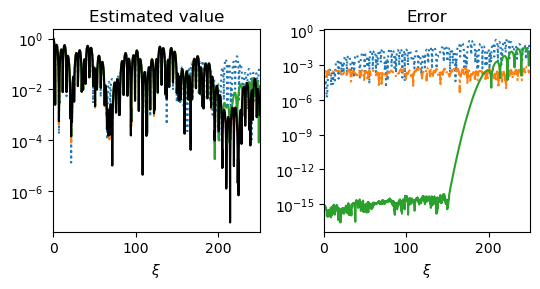

In [37]:
figure(figsize=(5.5,3))
     subplot(121)
semilogy(ξvals,abs.(ulam_ftr),"C0:",label="Ulam")
semilogy(ξvals,abs.(mcmc_ftr),"C1-.",label="Monte Carlo")
plot(ξvals,abs.(spectral_ftr),"C2",label="Cheb-Lag")
plot(ξvals,abs.(true_ftr),"k",label="True")

# legend()
xlim(0,250)
xlabel("\$\\xi\$")
# ylabel("Abs. value")
title("Estimated value")

subplot(122)
semilogy(ξvals,abs.(true_ftr.-ulam_ftr),"C0:",label="Ulam")
semilogy(ξvals,abs.(true_ftr.-mcmc_ftr),"C1-.",label="Monte Carlo")
semilogy(ξvals,abs.(true_ftr.-spectral_ftr),"C2",label="Cheb-Lag")
# legend()
xlim(0,250)
xlabel("\$\\xi\$")
# ylabel("Abs. value")
title("Error")


tight_layout()
savefig("../figures/Fourier.pdf")

In [38]:
ξvals_hi = 10^6 .+ (1:0.5:200)
mcmc_ftr_hi = [sum(cis.(ξ*xh))/T for ξ = ξvals_hi];
    true_ftr_hi = true_cantor_ft_fun.(ξvals_hi)


399-element Vector{Float64}:
 -0.0027586554794884395
 -0.00366398311137606
 -0.004145526540674398
 -0.0039245413433302645
 -0.0028304704159810667
 -0.0008639894775593496
  0.001775907359853851
  0.004711007726132028
  0.007448396890826775
  0.009478227970872834
  0.010383624498201434
  0.009937385708657221
  0.008161939434015705
  ⋮
  0.015277211903851675
  0.016349390754258297
  0.015275771210392624
  0.01218621519656938
  0.007611295599890784
  0.002387875981191134
 -0.0025110094874469437
 -0.006187323157399139
 -0.00802345628623907
 -0.00783342814739612
 -0.005921108074965286
 -0.0030262855761839136

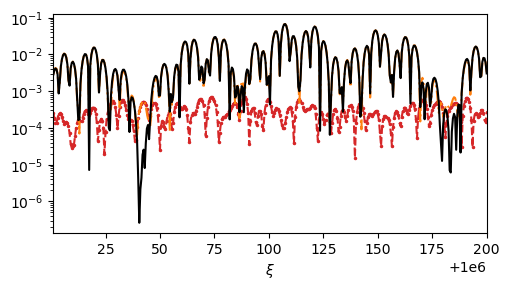

In [48]:
figure(figsize=(5.2,3))
plot(ξvals_hi,abs.(mcmc_ftr_hi - true_ftr_hi),"C3.--",markersize=3)
plot(ξvals_hi,abs.(mcmc_ftr_hi),"C1-.")
plot(ξvals_hi,abs.(true_ftr_hi),"k")
semilogy()       
xlim(extrema(ξvals_hi))
xlabel("\$\\xi\$")
tight_layout()
savefig("../figures/highfreq.pdf")